In [1]:
from sklearn.model_selection import train_test_split
import tensorflow as tf



In [2]:
import sys
sys.path.insert(1, '../Pre Processing Stage/')
sys.path.insert(1, '../Processing Stage/HoG')


from commonfunctions import *
from main import *
from hog import *

In [3]:
target_image_size=(500,500)



In [4]:
mssImages = process('../Data/ourDataset/cropped/MSS/', rem_noise=True,hist_eq=True,resize=True,target_size=target_image_size)

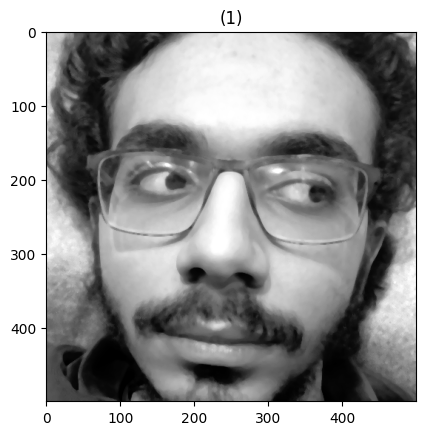

In [5]:
show_images([mssImages[5]])

In [6]:
abdelattyImages = process('../Data/ourDataset/cropped/Abdelatty/',
                    rem_noise=True, gamma_corre=True, hist_eq=True,resize=True,target_size=target_image_size,gamma=0.8)

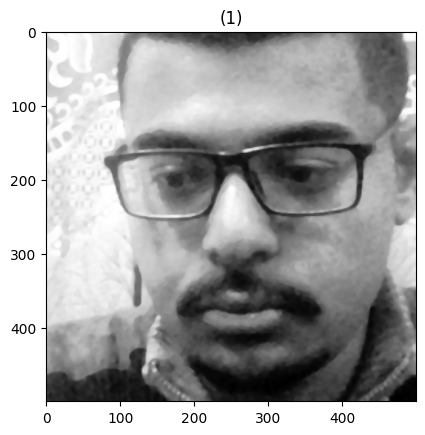

In [7]:
show_images([abdelattyImages[0]])

In [6]:
ismailImages = process('../Data/ourDataset/cropped/Ismail/',
                    rem_noise=True, hist_eq=True,resize=True,target_size=target_image_size)

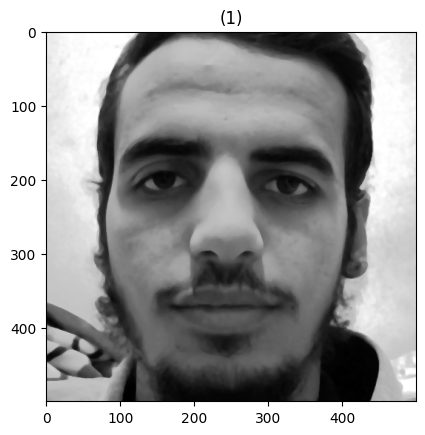

In [7]:
show_images([ismailImages[0]])

In [8]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomZoom(0.05, seed=42),
])

In [9]:
def getAugmentedList(images):
    copylist=np.copy(images)
    copylist = [tf.expand_dims(im, axis=-1) for im in copylist]
    copyAugmented = data_augmentation(copylist)

    return np.concatenate((copylist, copyAugmented), axis=0)

In [10]:
mssAugmented=getAugmentedList(mssImages)
abdelattyAugmented=getAugmentedList(abdelattyImages)
# ismailAugmented=getAugmentedList(ismailImages)


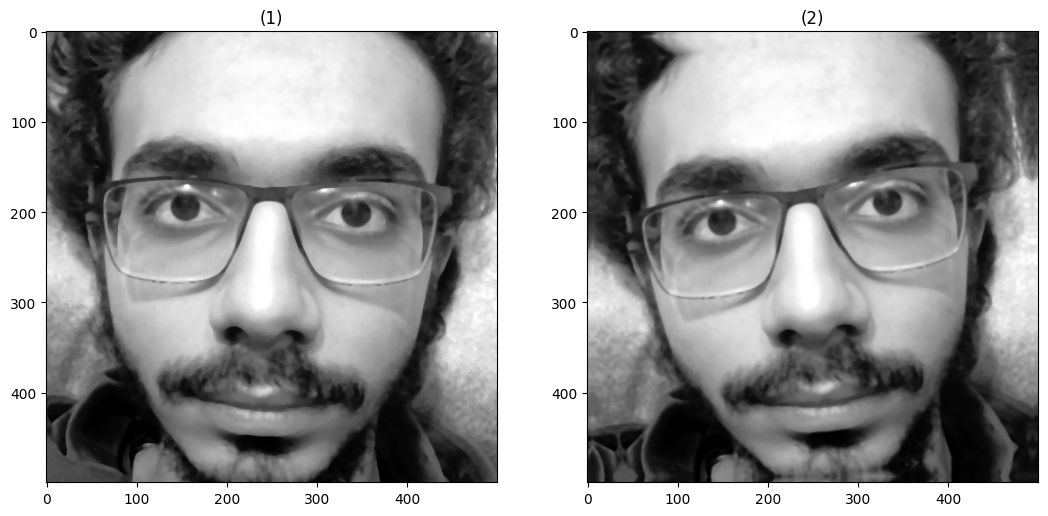

In [11]:
show_images([mssAugmented[0],mssAugmented[42]])

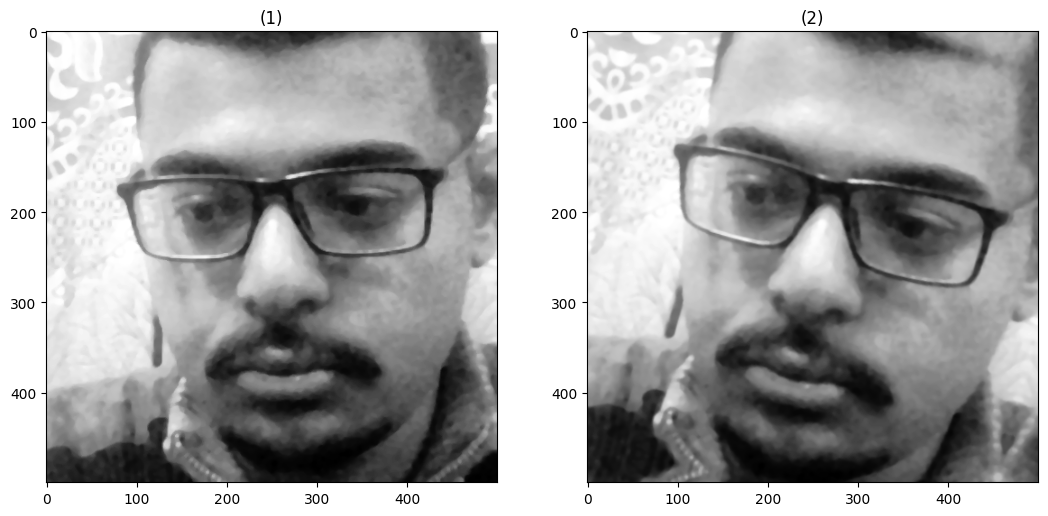

In [12]:
show_images([abdelattyAugmented[0],abdelattyAugmented[52]])


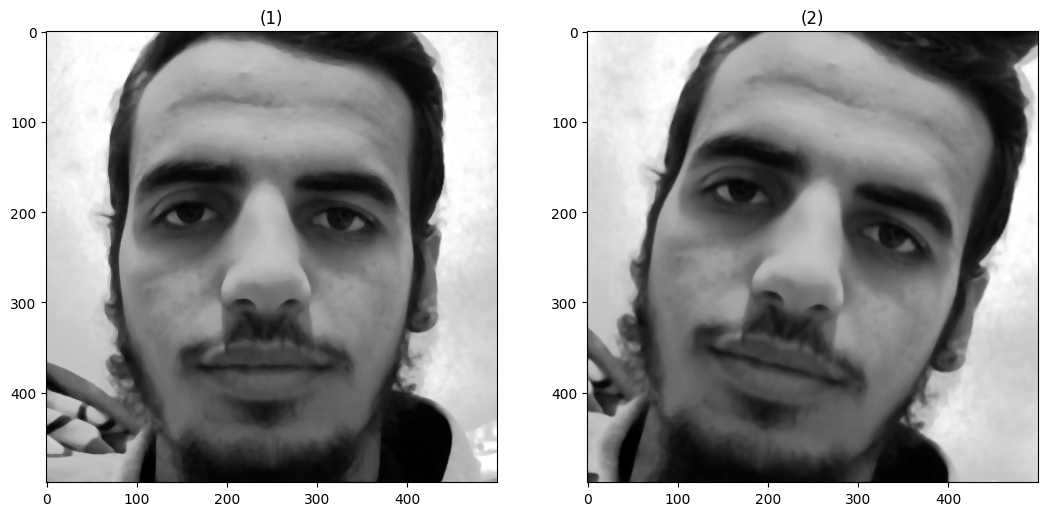

In [12]:
show_images([ismailAugmented[0],ismailAugmented[49]])


In [24]:
# def ComputeLBP(x, y, arr):
#     f = s = -1
#     value = 0
#     height, width = arr.shape
#     for i in range(8):
#         if (i == 3 or i == 7):
#             f = 0
#         elif (i > 3):
#             f = 1
#         if (i == 1 or i == 5):
#             s = 0
#         elif (i > 1 and i < 5):
#             s = 1
#         else:
#             s = -1
#         if (x+f > -1 and x+f < height and y+s > -1 and y+s < width):
#             value += pow(2, 7-i) if arr[x+f, y+s] > arr[x, y] else 0
#     return value


# def LBP(arr):
#     tempArr = np.copy(arr)
#     hight, width = tempArr.shape
#     for i in range(hight):
#         for j in range(width):
#             tempArr[i, j] = ComputeLBP(i, j, tempArr)
#     return tempArr


# def get_LBP_features(imagesList):
#     imList=[]
#     for image,index in zip(imagesList,range(len(imagesList))):
#         imList.append(LBP(image)/255)
#         print(index)

#     return imList

In [13]:
import numpy as np
from numba import cuda

@cuda.jit(device=True)
def ComputeLBP_cuda(x, y, arr):
    f = s = -1
    value = 0
    height, width = arr.shape
    for i in range(8):
        if (i == 3 or i == 7):
            f = 0
        elif (i > 3):
            f = 1
        if (i == 1 or i == 5):
            s = 0
        elif (i > 1 and i < 5):
            s = 1
        else:
            s = -1
        if (x+f > -1 and x+f < height and y+s > -1 and y+s < width):
            value += pow(2, 7-i) if arr[x+f, y+s] > arr[x, y] else 0
    return value

@cuda.jit
def LBP_kernel_cuda(arr, result):
    i, j = cuda.grid(2)
    if i < arr.shape[0] and j < arr.shape[1]:
        result[i, j] = ComputeLBP_cuda(i, j, arr)

def LBP_cuda(arr):
    tempArr = np.copy(arr)
    result = np.zeros_like(tempArr)
    threadsperblock = (16, 16)
    blockspergrid_x = int(np.ceil(arr.shape[0] / threadsperblock[0]))
    blockspergrid_y = int(np.ceil(arr.shape[1] / threadsperblock[1]))
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    LBP_kernel_cuda[blockspergrid, threadsperblock](tempArr, result)

    return result

def get_LBP_features_cuda(imagesList):
    imList = []
    for image, index in zip(imagesList, range(len(imagesList))):
        imList.append(LBP_cuda(image) / 255)
        print(index)

    return imList


In [14]:
lbp_mss=get_LBP_features_cuda([im.reshape(500,500)for im in  mssAugmented])
lbp_abdelatty=get_LBP_features_cuda([im.reshape(500,500)for im in  abdelattyAugmented])
# lbp_ismail=get_LBP_features_cuda([im.reshape(500,500)for im in  ismailAugmented])


c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\numba\cuda\cudadrv\devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103


In [27]:
# lbp_mss_cuda=get_lbp_features([im.reshape(1000,1000)for im in  mssAugmented])
# lbp_abdelatty_cuda=get_lbp_features_cuda([im.reshape(1000,1000)for im in  abdelattyAugmented])
# lbp_ismail_cuda=get_lbp_features_cuda([im.reshape(1000,1000)for im in  ismailAugmented])


In [15]:
lbp_mss=np.array(lbp_mss)
lbp_abdelatty=np.array(lbp_abdelatty)
# lbp_ismail=np.array(lbp_ismail)

# final_lbp=np.concatenate((lbp_mss, lbp_abdelatty,lbp_ismail), axis=0)
final_lbp = np.concatenate((lbp_mss, lbp_abdelatty), axis=0)

In [16]:
first_value = 0  # samir
second_value = 1  # abdelatty
third_value = 2  # ismail

# targets_lbp = np.array([first_value] * len(lbp_mss) + [second_value] * len(lbp_abdelatty)+[third_value]*len(lbp_ismail))
targets_lbp = np.array([first_value] * len(lbp_mss) +
                       [second_value]*len(lbp_abdelatty))

In [17]:
final_lbp.shape

(188, 500, 500)

In [18]:
final_lbp_flattened=np.array([np.ravel(i) for i in final_lbp])

In [19]:
final_lbp_flattened.shape

(188, 250000)

In [24]:
np.save('./numpyArrays/final_lbp_flattened.npy', final_lbp_flattened)
np.save('./numpyArrays/targets_lbp.npy', targets_lbp)

